In [111]:
%matplotlib inline
import math
import random as rd
import numpy as np
from scipy import spatial
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.animation import FuncAnimation
from statistics import mean

def arraysFromDots(points):
    xarr = []
    yarr = []
    for point in points:
        x, y = point
        xarr.append(x)
        yarr.append(y)
    xarr.append(points[0][0])
    yarr.append(points[0][1])
    return (xarr, yarr)

In [9]:
class SAO:
    
    def __init__(self, points, maxT=100, minT=0.1):
        
        self.points = points       # Текущий путь
        self.pointsQ = len(points) # Количество точек в пути
        self.temp = maxT           # Текущая температура
        self.minT = minT           # Минимальная температура

        self.paths = [self.points]                # Путь на каждой итерации
        self.dists = [self.pathDist(self.points)] # Длина пути на каждой итерации
        self.temps = [self.temp]                  # Температура на каждой итерации
        
        self.bestDist = self.dists[0]             # Лучшая дистанция
        self.bestDists = [self.bestDist]          # Лучшая дистанция на каждой итерации
        
    
    # Генерация нового пути
    def getNewPoints(self, points):
        newP = np.copy(self.points)
        f = rd.randint(0, self.pointsQ-1)
        l = rd.randint(0, self.pointsQ-1)
        while l == f:
            l = rd.randint(0, self.pointsQ-1)
        newP[f], newP[l] = newP[l], newP[f].copy()
        return newP

    
    # Расстояние между точками
    def dist(self, a, b):
        x1, y1 = a
        x2, y2 = b
        return ((x2-x1)**2 + (y2-y1)**2)**0.5
    
    
    # Длина пути
    def pathDist(self, points):
        res = 0
        for i in range(-1, self.pointsQ-1):
            res += self.dist(points[i], points[i+1])
        return res

    
    # Уменьшение температуры
    def decreaseTemp(self, temp):
        return self.temp * 0.999

    
    # Алгоритм отжига
    def execute(self):
        
        while self.temp > self.minT:
            
            # Получение нового пути
            newPoints = self.getNewPoints(self.points)
            
            # Текущая длина пути
            currDist = self.pathDist(self.points)
            
            # Разница между длинной текущего пути и длинной нового пути
            dE = self.pathDist(newPoints) - currDist
            
            # Если новый путь меньше, принимаем его
            if dE <= 0:
                self.points = newPoints
            
            # Если больше, принимаем с вероятностью p вычисленной по формуле
            else:
                p = self.temp*(math.e)**(-dE/self.temp)
                if p >= rd.randint(1, 100):
                    self.points = newPoints
            
            # Уменьшение температуры
            self.temp = self.decreaseTemp(self.temp)
            
            # Обновление данных
            if currDist < self.bestDist:
                self.bestDist = currDist
            self.bestDists.append(self.bestDist)
            self.paths.append(self.points)
            self.dists.append(currDist)
            self.temps.append(self.temp)

In [10]:
class ACO:
    
    def __init__(self, points, itr = 100, popul = 20, a = 0.01, b = 1.1, p = 0.15):
        
        self.points = points       # Координаты точек
        self.pointsQ = len(points) # Количество точек
        self.itr = itr             # Количество итераций
        self.popul = popul         # Количесвто муравьев в популяции
        self.a = a                 # Альфа
        self.b = b                 # Бетта
        self.p = p                 # p (испарение ферамона)
            
        self.dists = spatial.distance.cdist(points, points, metric='euclidean') # Матрица длин дуг
        self.pher = np.ones((self.pointsQ, self.pointsQ))                       # Матрица ферамонов
        self.pherDelta = np.zeros((self.pointsQ, self.pointsQ))                 # Матрица изменений ферамонов на каждой итерации
        
        # Матрица вероятностей (длинны дуг)
        self.distProb = np.array(list(map(lambda x: list(map(lambda y: 1/y if y != 0 else 0, x)), self.dists)))
        
        self.bestPath = None # Лучший путь
        self.bestDist = 0    # Лучшая дистанция
        
        self.bestPaths = []  # Лучшие пути (текущие для каждой итерации)
        self.bestDists = []  # Лучшие дистанции (текущие для каждой итерации)
        
        
    def execute(self):
        
        for i in range(self.itr):
            
            bestPath = None
            bestDist = 0
            
            for ant in range(self.popul):
                
                path = [list(self.points[0]), ]                       # Путь
                currI = 0                                             # Текущая точка
                dist = 0                                              # Дистанция
                probTable = self.distProb**self.a * self.pher**self.b # Ненормализованная матрица вероятностей
                probTable[:, currI] = np.zeros(self.pointsQ)
                
                for j in range(self.pointsQ-1):
                    
                    # Нормализованные вероятности выбора следущей точки
                    prob = probTable[currI]
                    prob /= prob.sum()
                    
                    # Выбор следущей точки и добавление ее в путь
                    newI = np.random.choice(range(self.pointsQ), size=1, p=prob)[0]
                    path.append(list(self.points[newI]))
                    
                    # Увелечение феромонов на выбранном пути и подсчет дистанции
                    self.pherDelta[currI, newI] += 1/self.dists[currI, newI]
                    dist += self.dists[currI, newI]
                    
                    # Изменение текущей точки и удаление ее из возможного выбора
                    currI = newI
                    probTable[:, currI] = np.zeros(self.pointsQ)
                    
                # Поиск лучшего пути из популяции
                if dist < bestDist or bestDist == 0:
                    bestDist = dist
                    bestPath = path
            
            # Поиск лучшего пути на каждой итерации
            if bestDist < self.bestDist or self.bestDist == 0:
                self.bestDist = bestDist
                self.bestPath = bestPath
            
            # Изменение ферамонов
            self.pher = np.array(list(map(lambda x: (1-self.p)*x, self.pher))) + self.pherDelta
            
            # Текущий лучший путь и дистанция
            self.bestPaths.append(self.bestPath)
            self.bestDists.append(self.bestDist)

In [17]:
avgPath = []
saoPath = []
acoPath = []

In [18]:
for i in range(100):

    orig_points = np.random.rand(20, 2)
    start_points = orig_points.copy()

    maxT = 100
    minT = 0.1

    sao = SAO(start_points, maxT, minT)
    sao.execute()

    avgPath.append(sao.bestDists[0])
    saoPath.append(sao.bestDists[-1])


    itr = 200
    popul = 40
    a = 0.01
    b = 1.1
    p = 0.15

    aco = ACO(start_points, itr, popul, a, b, p)
    aco.execute()

    acoPath.append(aco.bestDists[-1])
    
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [19]:
print(avgPath)
print(saoPath)
print(acoPath)

[10.658899301569596, 11.073830831220345, 10.395151360875511, 8.85893541067965, 12.03097969600612, 8.767635918597673, 11.239016409753583, 9.341433351099948, 9.571379344328388, 11.558677814170899, 8.203820929152178, 10.977189136043766, 11.24038783906663, 9.114681153662156, 11.265651732702427, 11.096901664189666, 9.162170169027787, 11.900412339456963, 10.410438428405211, 12.447044086288866, 11.79807970047162, 11.090918095937521, 10.241253929483218, 10.091876385103484, 10.434452439694752, 11.52502062455176, 10.558831559984398, 11.606751961596, 10.27317026888017, 11.37765090196115, 8.347530073181671, 9.217908046321158, 10.827342116691053, 12.161143117832177, 12.711998677595576, 11.608640185612193, 10.53217110670044, 10.968701526922327, 9.363473387201918, 12.489814720061261, 11.372657868240887, 10.873316752716644, 10.473701482871302, 11.454473885137334, 10.884263026399628, 9.260020461588736, 9.322376693700903, 10.520535567109745, 9.336627947438755, 10.038861949403925, 9.807365213433219, 11.7

In [131]:
avgR = mean(avgPath)
avgSAO = mean(saoPath)
avgACO = mean(acoPath)
saoD = avgR/avgSAO
acoD = avgR/avgACO

                       Средняя длина случайного пути: 10.31        
       Средняя длина пути, найденного методом отжига:  4.39        Уменьшение в 2.35 раза (57.42%)        
Средняя длина пути, найденного муравьиным алгоритмом:  3.46        Уменьшение в 2.98 раза (66.44%)


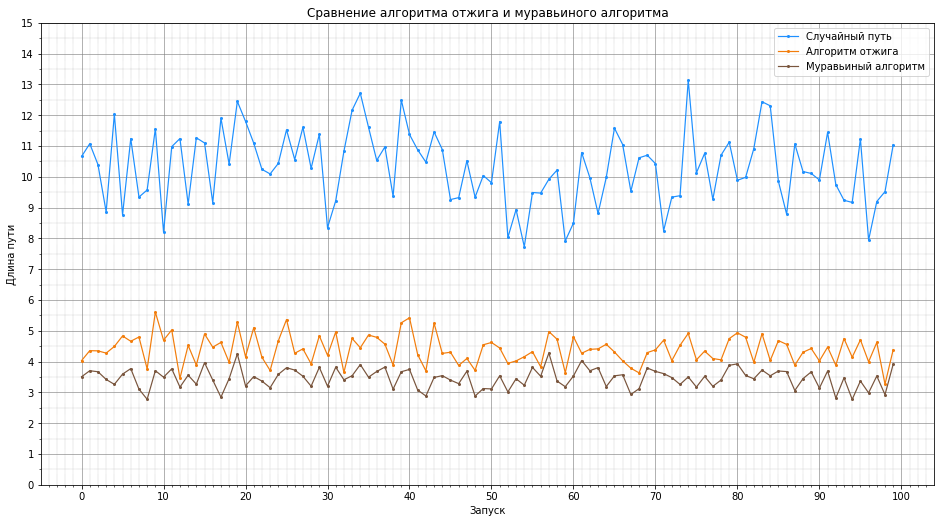

In [140]:
print(f'                       Средняя длина случайного пути: {round(avgR, 2)}\
        \n       Средняя длина пути, найденного методом отжига:  {round(avgSAO, 2)}\
        Уменьшение в {round(saoD, 2)} раза ({round((avgR-avgSAO)/avgR*100, 2)}%)\
        \nСредняя длина пути, найденного муравьиным алгоритмом:  {round(avgACO, 2)}\
        Уменьшение в {round(acoD, 2)} раза ({round((avgR-avgACO)/avgR*100, 2)}%)')


fig = plt.figure(figsize=(16, 8.5))
ax = fig.add_subplot()

ax.set_title('Сравнение алгоритма отжига и муравьиного алгоритма')
ax.set_xlabel('Запуск')
ax.set_ylabel('Длина пути')

ax.set_ylim(0, 15)

ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax.grid(which='major', color = 'gray', linewidth=0.6)
ax.grid(which='minor', color = 'gray', linestyle = ':', linewidth=0.4)

ax.plot(avgPath, color='#1E90FF', linewidth=1.2, marker='o', markersize=2, label='Случайный путь')
ax.plot(saoPath, color='#f27d0c', linewidth=1.2, marker='o', markersize=2, label='Алгоритм отжига')
ax.plot(acoPath, color='#79553D', linewidth=1.2, marker='o', markersize=2, label='Муравьиный алгоритм')

ax.legend();